## Imports

In [1]:
import utils, models_preprocessing, metrics
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os
import PIL.Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from keras import models
from keras.models import save_model, load_model
from keras.preprocessing import image
from quiver_engine import server

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Prepare data

In [2]:
data = np.load('data/imadjust.npy')
labels = np.load('labels/classification.npy')

## Model function

In [3]:
# model_function = models_preprocessing.compiledConvnet
model_function = models_preprocessing.compiledRegularizedConvnet
auroc = metrics.auroc
accuracy = metrics.accuracy
text = metrics.basicTextMetrics

In [4]:
%matplotlib inline

## Data split

In [5]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(data, labels, test_size=0.2)

## Train

In [ ]:
## Run 1: Compiled Regularized ConvNet
model = utils.train(model_function(), 40, Xtrain, Ytrain)

## Save model, Print model summary

In [6]:
os.makedirs('models', exist_ok=True)
PATH = 'models/'

In [ ]:
save_model(model, f'{PATH}model_reg_05.hdf5')

In [7]:
model = load_model(f'{PATH}model_reg_05.hdf5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 50, 64)        2368      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1936)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               247936    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
__________

## Predictions/Probabilities for the whole dataset

In [8]:
preds = model.predict_classes(data)
probs = model.predict(data)

## Incorrect predictions

In [9]:
incorrect_preds = [(i, preds[i]) for i in range(len(preds)) if preds[i] != labels[i]]

In [10]:
incorrect_preds

[(15, array([0], dtype=int32)),
 (36, array([0], dtype=int32)),
 (53, array([0], dtype=int32)),
 (54, array([0], dtype=int32)),
 (62, array([0], dtype=int32)),
 (68, array([0], dtype=int32)),
 (91, array([0], dtype=int32)),
 (116, array([0], dtype=int32)),
 (147, array([0], dtype=int32)),
 (149, array([0], dtype=int32)),
 (166, array([0], dtype=int32)),
 (170, array([0], dtype=int32)),
 (176, array([0], dtype=int32)),
 (185, array([1], dtype=int32)),
 (208, array([0], dtype=int32)),
 (218, array([0], dtype=int32)),
 (238, array([0], dtype=int32)),
 (243, array([0], dtype=int32)),
 (245, array([0], dtype=int32)),
 (248, array([1], dtype=int32)),
 (251, array([0], dtype=int32)),
 (262, array([0], dtype=int32)),
 (266, array([0], dtype=int32)),
 (272, array([0], dtype=int32)),
 (273, array([0], dtype=int32)),
 (291, array([0], dtype=int32)),
 (304, array([0], dtype=int32)),
 (309, array([0], dtype=int32)),
 (314, array([0], dtype=int32)),
 (322, array([0], dtype=int32)),
 (343, array([0],

In [11]:
model.evaluate(Xtest, Ytest)

4000/4000 [==============================] - 13s 3ms/step


[0.22625466465950012, 0.92874999999999996]

## Refactored functions

In [12]:
def get_im_tensor(im_data):
    
    img = PIL.Image.fromarray(im_data)
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    
    return img_tensor    

In [13]:
def actn_model(img_tensor, model):
    
    layer_outputs = [layer.output for layer in model.layers[:4]]
    activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model.predict(img_tensor)
    
    return activations

In [14]:
def plot_activations(actn, f_num):
    
    plt.matshow(actn[0, :, :, f_num], cmap='viridis')

In [15]:
def plot_all(activations, model):
    
    layer_names = []

    for layer in model.layers[:4]:
        layer_names.append(layer.name)

    images_per_row = 16

    for layer_name, layer_activation in zip(layer_names, activations):
    
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size*n_cols, images_per_row*size))
    
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0, :, :, col*images_per_row + row]
            
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            
                display_grid[col*size : (col+1)*size, row*size : (row+1)*size] = channel_image
    
        scale = 1./size
        plt.figure(figsize=(scale*display_grid.shape[1],
                            scale*display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        #plt.imsave(f'{layer_name}.jpg', display_grid)

In [16]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### True positive

In [17]:
img_tensor = get_im_tensor(data[0])

In [18]:
first_layer_activation = actn_model(img_tensor, model)[0]

In [19]:
first_layer_activation.shape

(1, 50, 50, 64)

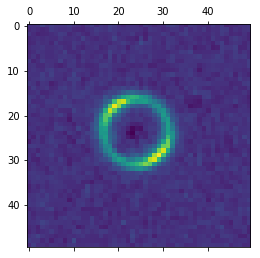

In [20]:
plot_activations(first_layer_activation, 15)

In [21]:
activations = actn_model(img_tensor, model)

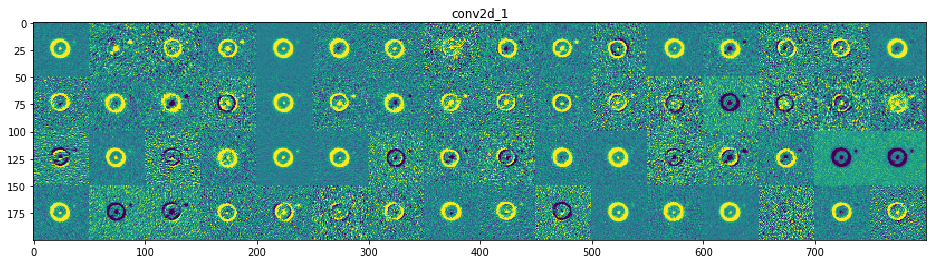

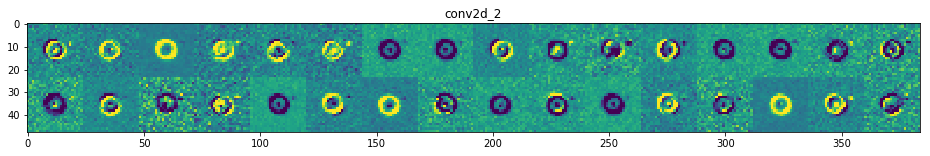

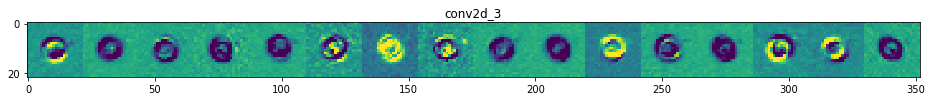

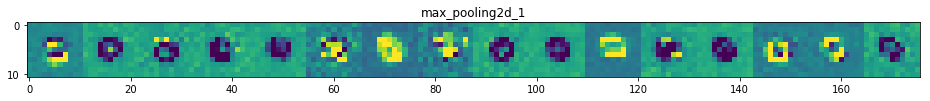

In [22]:
plot_all(activations, model)

### True negative

In [23]:
img_tensor = get_im_tensor(data[1])

In [24]:
first_layer_activation = actn_model(img_tensor, model)[0]

In [25]:
first_layer_activation.shape

(1, 50, 50, 64)

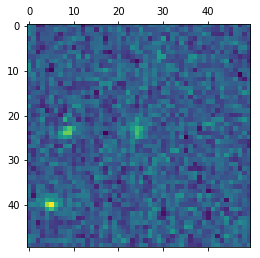

In [26]:
plot_activations(first_layer_activation, 15)

In [27]:
activations = actn_model(img_tensor, model)

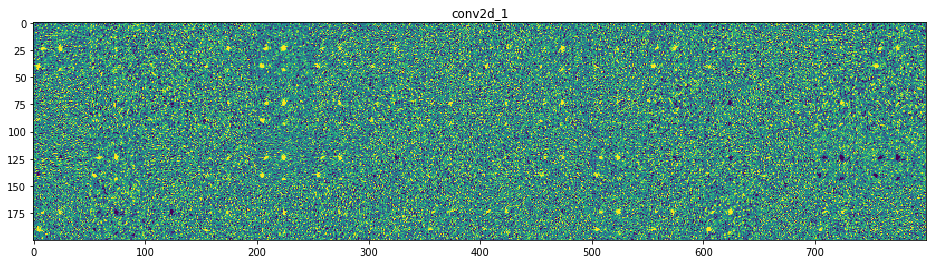

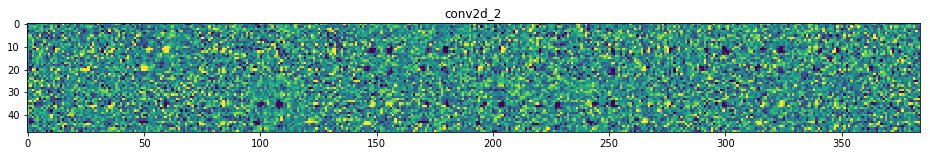

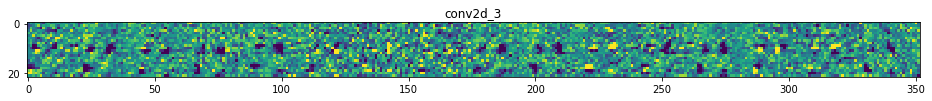

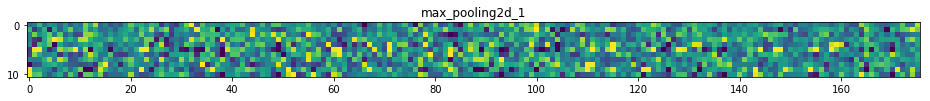

In [28]:
plot_all(activations, model)

### False positive

In [29]:
img_tensor = get_im_tensor(data[185])

In [30]:
first_layer_activation = actn_model(img_tensor, model)[0]

In [31]:
first_layer_activation.shape

(1, 50, 50, 64)

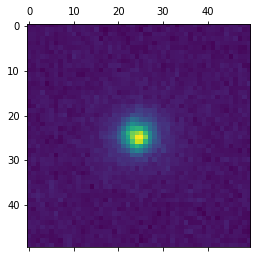

In [32]:
plot_activations(first_layer_activation, 15)

In [33]:
activations = actn_model(img_tensor, model)

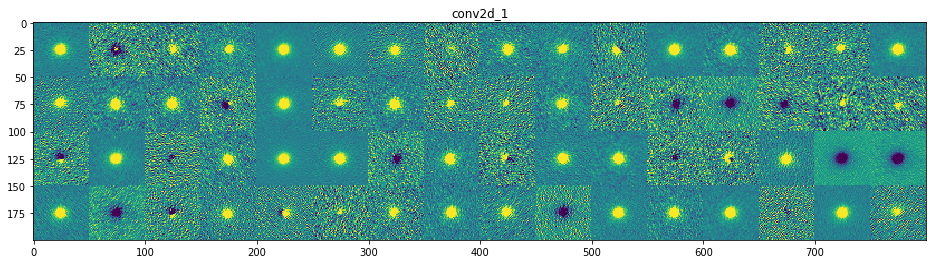

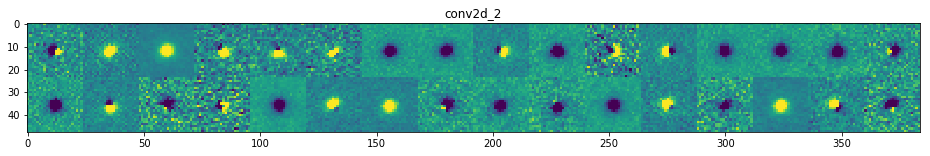

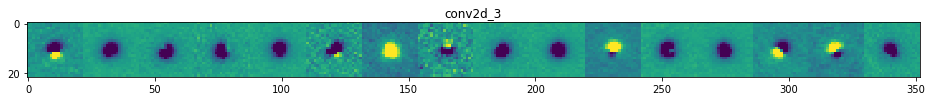

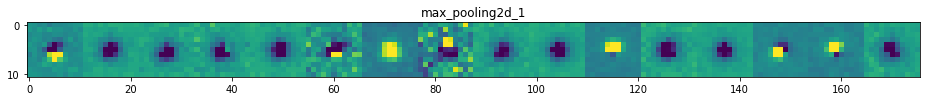

In [34]:
plot_all(activations, model)

### False negative

In [35]:
img_tensor = get_im_tensor(data[15])

In [36]:
first_layer_activation = actn_model(img_tensor, model)[0]

In [37]:
first_layer_activation.shape

(1, 50, 50, 64)

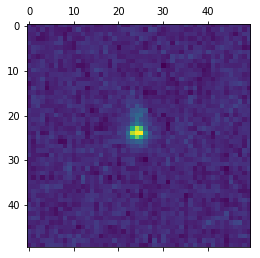

In [38]:
plot_activations(first_layer_activation, 15)

In [39]:
activations = actn_model(img_tensor, model)

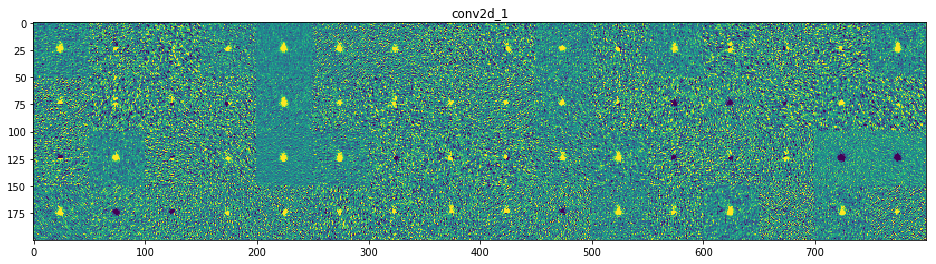

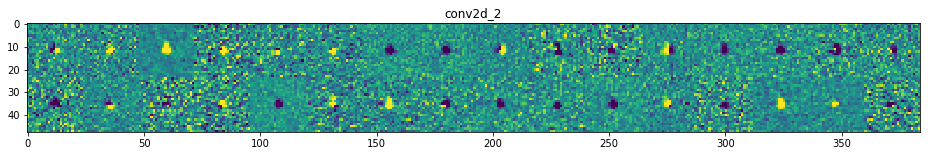

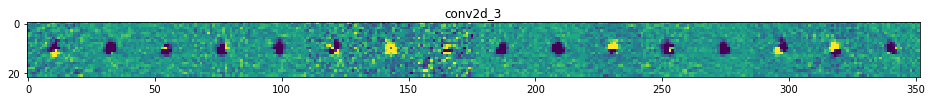

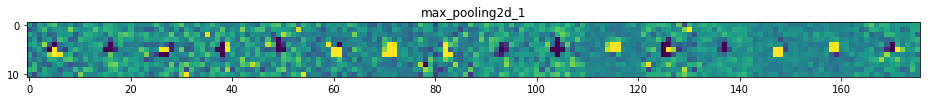

In [40]:
plot_all(activations, model)

## Plot confusion matrix

In [41]:
cm = confusion_matrix(labels, preds)

[[11826   153]
 [ 1254  6767]]


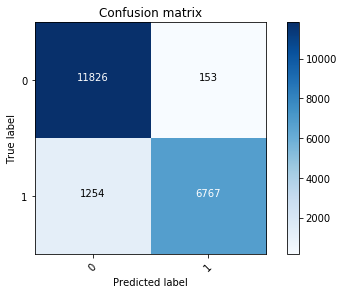

In [42]:
plot_confusion_matrix(cm, [0,1])

In [43]:
len(preds[preds==1])

6920

In [44]:
len(labels[labels==1])

8021

## Gradient Class Activation Maps